In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import misc
import imageio
import glob
from PIL import Image


In [2]:
def get_patches_custom(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    
    Args:
        img_arr (numpy.ndarray): [description]
        size (int, optional): [description]. Defaults to 256.
        stride (int, optional): [description]. Defaults to 256.
    
    Raises:
        ValueError: [description]
        ValueError: [description]
    
    Returns:
        numpy.ndarray: [description]
    """    
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping
        j_max = img_arr.shape[1] // stride - overlapping
        for i in range(i_max):
            for j in range(j_max):
                # print(i*stride, i*stride+size)
                # print(j*stride, j*stride+size)
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    # print(i*stride, i*stride+size)
                    # print(j*stride, j*stride+size)
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)

In [4]:
from os import listdir
from os.path import isfile, join

In [8]:
def create_dataset(path_img, path_mask, crop_size=64, num_labels=3):

    filename_img = [f for f in listdir(path_img) if isfile(join(path_img, f))]
    filename_mask = [f for f in listdir(path_mask) if isfile(join(path_mask, f))]
    w_size = np.arange(0,len(filename_img))
    h_size = w_size.copy()
    n=0
    x_crops_image = np.zeros((0, crop_size, crop_size, 3))
    x_crops_mask =  np.zeros((0, crop_size, crop_size, 3))
    label_lens = np.zeros((num_labels,1))
    
    for n in range(0,len(filename_img)):       
        print(filename_img[n])
        image = imageio.imread(path_img+"/" +filename_img[n])[:,:,0:3]
        w_size[n] = image.shape[0]
        h_size[n] = image.shape[1]

        mask = imageio.imread(path_mask+"/"+filename_mask[n])[:,:,0:3]

        if  w_size[n]> h_size[n]:
            image = np.swapaxes(image,0,1)
            tmp = w_size[n]
            w_size[n] = h_size[n]
            h_size[n] = tmp
            
        x_crops = get_patches_custom(
            img_arr=image.astype(int), # required - array of images to be cropped
            size=crop_size, # default is 256
            stride=crop_size) # default is 256
        x_crops.astype(np.uint8)
        
        print(x_crops.shape)
        x_crops_image = np.append(x_crops_image, x_crops, axis=0)
        
        del(x_crops)
        
        x_crops = get_patches_custom(
            img_arr=mask.astype(int), # required - array of images to be cropped
            size=crop_size, # default is 256
            stride=crop_size) # default is 256
        x_crops.astype(np.uint8)

    
        x_crops_mask = np.append(x_crops_mask, x_crops, axis=0)
        print(x_crops_mask.shape)
        
    len_dataset = x_crops_image.shape[0]
    y_crops = np.zeros((len_dataset, 1))

    for k in range(len_dataset):
        sum_red = np.sum(np.sum(x_crops_mask[k,:,:,0], axis=0))/crop_size**2/255
        sum_green = np.sum(np.sum(x_crops_mask[k,:,:,1], axis=0))/crop_size**2/255

        if sum_red >= 0.55:
            y_crops[k] = 1
            label_lens[1,0] = label_lens[1,0] + 1 
        else:
            y_crops[k] = 0
            label_lens[0,0] = label_lens[0,0] + 1
        
    ind = np.argsort(y_crops, axis=0)
    x_crops_image[ind,:,:,:].shape
    x_sort = np.squeeze(x_crops_image[ind,:,:,:])
    y_sort = y_crops[ind].squeeze(axis=1)
    
    return x_sort.astype(np.uint8), y_sort.astype(np.uint8), label_lens.astype(np.int32)


In [9]:
#paths for images and their masks folders

path_img = r"C:\Users\adoro\Documents\AI\dataset_folder\image"
path_mask = r"C:\Users\adoro\Documents\AI\dataset_folder\mask"
crop_size = 80 #size of croppped segments
num_labels = 2 #number of classes

a, b, label_lens = create_dataset(path_img, path_mask, crop_size=crop_size, num_labels=num_labels)

cut_EVBH3-PL10A-2_0.20.png
(161750, 16, 16, 3)
(161750, 16, 16, 3)
cut_EVBH3-PL1A-0_0.20.png
(186750, 16, 16, 3)
(348500, 16, 16, 3)


In [10]:
label_lens

array([[247209],
       [101291]])

In [11]:
def take_data_from_dataset(x_data, y_data, label_lens, lens = [100,100,100]):
    labels = np.zeros((len(label_lens),1))
    n=0
    x_result = np.zeros((0, x_data.shape[1],x_data.shape[2],x_data.shape[3]), dtype="uint8")
    y_result =  np.zeros((0,1), dtype="uint8")
    for k in range(len(lens)):
        x = x_data[n:n+label_lens[k,0],:,:,:]
        y = y_data[n:n+label_lens[k,0],:]
        rand_ind = (np.random.choice(label_lens[k][0], size=lens[k], replace=False)).astype(int)
        print(x_result.shape)
        print( x[rand_ind,:,:,:].shape)
        x_result = np.append(x_result, x[rand_ind,:,:,:], axis=0)
        print(y_result.shape)
        print( y[rand_ind,:].shape)
        y_result = np.append(y_result, y[rand_ind,:], axis=0)
        n = n+label_lens[k,0]
    return x_result.astype(np.uint8), y_result.astype(np.uint8)
    
    

In [12]:
#cut dataset - set neccessary number of every class items

lens = [50000,50000]
aa, bb = take_data_from_dataset(a, b, label_lens, lens)

#save dataset in .npz format
np.savez('crop16_1A0_10A2_50k', aa, bb, lens)

(0, 16, 16, 3)
(50000, 16, 16, 3)
(0, 1)
(50000, 1)
(50000, 16, 16, 3)
(50000, 16, 16, 3)
(50000, 1)
(50000, 1)


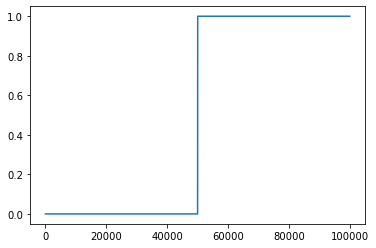

In [13]:
plt.plot(bb)

In [43]:
#check the dataset

def plot_random_Images(images_arr, y):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    rand_num = np.random.randint(0, len(y), size=5)
    print(rand_num)
    for k in range(0,5):
#         img, y_label, ax in zip(images_arr[rand_num], y[rand_num], axes[0:5]):
    # img = np.round(img/np.max(img))
        axes[k].imshow(images_arr[rand_num[k]])
        axes[k].set_xlabel(str(y[rand_num[k]]))

    plt.tight_layout()
    plt.show()

[10656  3997  7517 10925  6170]


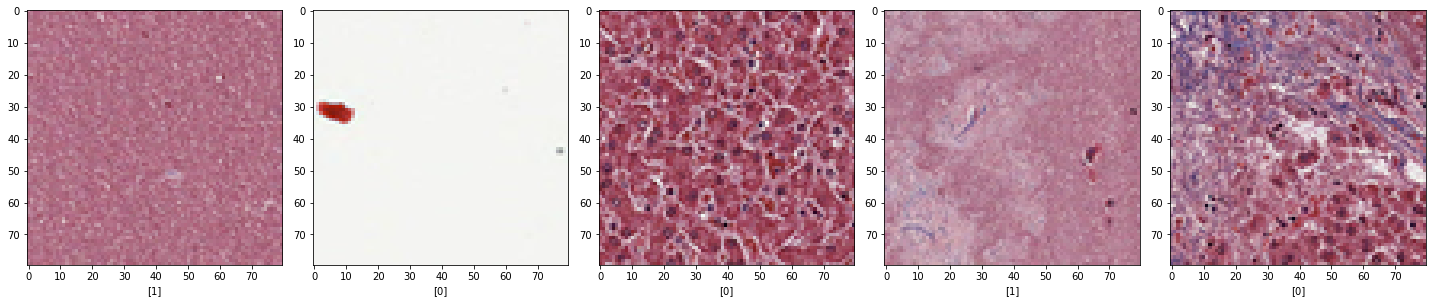

In [49]:
plot_random_Images(aa, bb)